## **Notebook to make predictions with Rhiannon data and SPOT** 

By Christina Schenk and Garrett Roell

Tested on biodesign_3.7 kernel on jprime

###  predictions and evaluations
This notebook predicts fluxes for R. opacus cultures growing with glucose.

#### **Data Labels**:

#### Rhiannon transcriptomics data: 
* WT 1.0 g/L Glucose (**WT-G**) (3 trials)

#### Combined with Rhiannon 2018 metabolomics and OD data:
* Metabolomics and OD data for WT Glucose (**WT-G**)
                                               

### Method: 
<ol>
<li>Predict fluxes with SPOT</li>
<li>Compare predictions with 13CMFA: Scatter plots and flux maps</li>
<li>Load file with observed growth rates (Notebook E)</li>
<li>Save growth rate predictions to csv file</li>
</ol>



##### **Import python packages**

In [1]:
import os
import sys
import pandas as pd
import numpy as np
import cobra
import scipy.stats
#import cplex
%matplotlib inline

import matplotlib
from matplotlib import pyplot as plt
from matplotlib.offsetbox import (TextArea, DrawingArea, OffsetImage,
                                  AnnotationBbox)
from matplotlib.cbook import get_sample_data
import matplotlib.image as mpimg
import matplotlib.cm as cm

from edd_utils import login, export_study, export_metadata

from sklearn.metrics import r2_score

SourceDir = '../src'
sys.path.append(SourceDir)
from ensemblemethods import SPOT
from utils import *

output_dir = '../plots/'
from plot import *

#### **Load Genome Scale Model**

In [2]:
model = cobra.io.read_sbml_model("../models/Ropacus_annotated_curated.xml")

#### **Load Transcript Data**

In [3]:
# read transcripts and isolate wildtype glucose data
transcript_df = pd.read_csv('../data/transcripts/csv/henson_CPM_melted.csv')
transcript_df = transcript_df[transcript_df['Line Name'].str.contains("WT-Glu")]

# separate data from different time points
transcript_df_T1 = transcript_df[transcript_df['Time'] == 10]
transcript_df_T2 = transcript_df[transcript_df['Time'] == 13]

# preview data
display(transcript_df_T1.head())
display(transcript_df_T2.head())

,Line Name,Measurement Type,Time,Count,Units
6,WT-Glu-R1,WP_005263480_1,10,27.446117,CPM
7,WT-Glu-R2,WP_005263480_1,10,27.543845,CPM
8,WT-Glu-R3,WP_005263480_1,10,26.797758,CPM
60,WT-Glu-R1,WP_005249107_1,10,355.352526,CPM
61,WT-Glu-R2,WP_005249107_1,10,349.533393,CPM


,Line Name,Measurement Type,Time,Count,Units
9,WT-Glu-R1,WP_005263480_1,13,15.584245,CPM
10,WT-Glu-R2,WP_005263480_1,13,22.444427,CPM
11,WT-Glu-R3,WP_005263480_1,13,20.433310,CPM
63,WT-Glu-R1,WP_005249107_1,13,219.798570,CPM
64,WT-Glu-R2,WP_005249107_1,13,328.518773,CPM


#### **Run SPOT for Each Condition**

In [4]:
# create dictionary to hold spot solutions
spot_solutions = {}

# loop over trials
for time in ['T1', 'T2']:
    for trial in ['WT-Glu-R1', 'WT-Glu-R2','WT-Glu-R3']:
        
        # display trial name
        trial_number = trial.split('-R')[1]
        trial_name = f'glucose_spot_{time.lower()}_{trial_number}'
        print(trial_name)
        
        # get the data for that trial
        transcriptomics = []
        if time == 'T1':
            transcriptomics = transcript_df_T1[transcript_df_T1['Line Name'] == trial]
        else:
            transcriptomics = transcript_df_T2[transcript_df_T2['Line Name'] == trial]

        # map the transcripts to genome scale reactions
        trans_data = construct_trans_df(transcriptomics, trial)
        
        # run spot to get genome scale fluxes
        spot_sol = spot_pred(model, trans_data, trial, 'glucose', sub_uptake_rate=100)
        
        print(f"The glucose uptake rate is {spot_sol['EX_glc__D_e']}")
        
        # add spot solution to dictionary
        spot_solutions[trial_name] = spot_sol

glucose_spot_t1_1


{'EX_ca2_e': inf,
 'EX_cl_e': inf,
 'EX_cobalt2_e': inf,
 'EX_cu2_e': inf,
 'EX_fe2_e': inf,
 'EX_fe3_e': inf,
 'EX_glc__D_e': inf,
 'EX_h2o_e': inf,
 'EX_h_e': inf,
 'EX_k_e': inf,
 'EX_mg2_e': inf,
 'EX_mn2_e': inf,
 'EX_mobd_e': inf,
 'EX_nh4_e': inf,
 'EX_o2_e': inf,
 'EX_pi_e': inf,
 'EX_so4_e': inf,
 'EX_zn2_e': inf}

The glucose uptake rate is -0.039035393089904225
glucose_spot_t1_2


{'EX_ca2_e': inf,
 'EX_cl_e': inf,
 'EX_cobalt2_e': inf,
 'EX_cu2_e': inf,
 'EX_fe2_e': inf,
 'EX_fe3_e': inf,
 'EX_glc__D_e': inf,
 'EX_h2o_e': inf,
 'EX_h_e': inf,
 'EX_k_e': inf,
 'EX_mg2_e': inf,
 'EX_mn2_e': inf,
 'EX_mobd_e': inf,
 'EX_nh4_e': inf,
 'EX_o2_e': inf,
 'EX_pi_e': inf,
 'EX_so4_e': inf,
 'EX_zn2_e': inf}

The glucose uptake rate is -0.03777249209846778
glucose_spot_t1_3


{'EX_ca2_e': inf,
 'EX_cl_e': inf,
 'EX_cobalt2_e': inf,
 'EX_cu2_e': inf,
 'EX_fe2_e': inf,
 'EX_fe3_e': inf,
 'EX_glc__D_e': inf,
 'EX_h2o_e': inf,
 'EX_h_e': inf,
 'EX_k_e': inf,
 'EX_mg2_e': inf,
 'EX_mn2_e': inf,
 'EX_mobd_e': inf,
 'EX_nh4_e': inf,
 'EX_o2_e': inf,
 'EX_pi_e': inf,
 'EX_so4_e': inf,
 'EX_zn2_e': inf}

The glucose uptake rate is -0.038862021675523155
glucose_spot_t2_1


{'EX_ca2_e': inf,
 'EX_cl_e': inf,
 'EX_cobalt2_e': inf,
 'EX_cu2_e': inf,
 'EX_fe2_e': inf,
 'EX_fe3_e': inf,
 'EX_glc__D_e': inf,
 'EX_h2o_e': inf,
 'EX_h_e': inf,
 'EX_k_e': inf,
 'EX_mg2_e': inf,
 'EX_mn2_e': inf,
 'EX_mobd_e': inf,
 'EX_nh4_e': inf,
 'EX_o2_e': inf,
 'EX_pi_e': inf,
 'EX_so4_e': inf,
 'EX_zn2_e': inf}

The glucose uptake rate is -0.03413179317226763
glucose_spot_t2_2


{'EX_ca2_e': inf,
 'EX_cl_e': inf,
 'EX_cobalt2_e': inf,
 'EX_cu2_e': inf,
 'EX_fe2_e': inf,
 'EX_fe3_e': inf,
 'EX_glc__D_e': inf,
 'EX_h2o_e': inf,
 'EX_h_e': inf,
 'EX_k_e': inf,
 'EX_mg2_e': inf,
 'EX_mn2_e': inf,
 'EX_mobd_e': inf,
 'EX_nh4_e': inf,
 'EX_o2_e': inf,
 'EX_pi_e': inf,
 'EX_so4_e': inf,
 'EX_zn2_e': inf}

The glucose uptake rate is -0.038311681202783915
glucose_spot_t2_3


{'EX_ca2_e': inf,
 'EX_cl_e': inf,
 'EX_cobalt2_e': inf,
 'EX_cu2_e': inf,
 'EX_fe2_e': inf,
 'EX_fe3_e': inf,
 'EX_glc__D_e': inf,
 'EX_h2o_e': inf,
 'EX_h_e': inf,
 'EX_k_e': inf,
 'EX_mg2_e': inf,
 'EX_mn2_e': inf,
 'EX_mobd_e': inf,
 'EX_nh4_e': inf,
 'EX_o2_e': inf,
 'EX_pi_e': inf,
 'EX_so4_e': inf,
 'EX_zn2_e': inf}

The glucose uptake rate is -0.0328176387216929


In [5]:
spot_solutions['glucose_spot_t1_1']['EX_glc__D_e']

-0.039035393089904225

#### **Save Glucose SPOT Genome Scale Fluxes**

In [6]:
# loop over solution dictionary. Convert the flux solutions to dataframes
for trial_name, flux_solution in spot_solutions.items():
    flux_df = spot_solution_to_df(model, flux_solution)
    flux_df.to_csv(f'../data/genome_scale_fluxes/{trial_name}.csv', index=False)

    display(flux_df.head(5))

,reaction_id,reaction_name,reaction_reaction,flux
0,12DGR140tipp,"1,2 diacylglycerol transport via flipping (per...",12dgr140_p --> 12dgr140_c,-1.617031e-12
1,13PPDH,"1,3-propanediol dehydrogenase",3hppnl_c + h_c + nadh_c <=> 13ppd_c + nad_c,0.000000e+00
2,1P2CBXLCYCL,1 Pyrroline 2 carboxylate cyclation,5a2opntn_c <=> 1p2cbxl_c + h2o_c + h_c,-2.761901e-12
3,1P2CBXLR,Delta1 piperideine 2 carboxylate reductase,1p2cbxl_c + 2.0 h_c + nadph_c --> nadp_c + pro...,5.172933e-11
4,23CTI1,Decenyl coa cis trans isomerization cis dec 3...,decoa_c --> dc2coa_c + h_c,-1.064223e-12


,reaction_id,reaction_name,reaction_reaction,flux
0,12DGR140tipp,"1,2 diacylglycerol transport via flipping (per...",12dgr140_p --> 12dgr140_c,-4.032962e-12
1,13PPDH,"1,3-propanediol dehydrogenase",3hppnl_c + h_c + nadh_c <=> 13ppd_c + nad_c,0.000000e+00
2,1P2CBXLCYCL,1 Pyrroline 2 carboxylate cyclation,5a2opntn_c <=> 1p2cbxl_c + h2o_c + h_c,-5.574815e-12
3,1P2CBXLR,Delta1 piperideine 2 carboxylate reductase,1p2cbxl_c + 2.0 h_c + nadph_c --> nadp_c + pro...,5.567889e-11
4,23CTI1,Decenyl coa cis trans isomerization cis dec 3...,decoa_c --> dc2coa_c + h_c,-2.128176e-13


,reaction_id,reaction_name,reaction_reaction,flux
0,12DGR140tipp,"1,2 diacylglycerol transport via flipping (per...",12dgr140_p --> 12dgr140_c,-3.064117e-12
1,13PPDH,"1,3-propanediol dehydrogenase",3hppnl_c + h_c + nadh_c <=> 13ppd_c + nad_c,-4.336809e-19
2,1P2CBXLCYCL,1 Pyrroline 2 carboxylate cyclation,5a2opntn_c <=> 1p2cbxl_c + h2o_c + h_c,-5.389457e-12
3,1P2CBXLR,Delta1 piperideine 2 carboxylate reductase,1p2cbxl_c + 2.0 h_c + nadph_c --> nadp_c + pro...,9.534864e-11
4,23CTI1,Decenyl coa cis trans isomerization cis dec 3...,decoa_c --> dc2coa_c + h_c,5.506562e-13


,reaction_id,reaction_name,reaction_reaction,flux
0,12DGR140tipp,"1,2 diacylglycerol transport via flipping (per...",12dgr140_p --> 12dgr140_c,-9.214600e-12
1,13PPDH,"1,3-propanediol dehydrogenase",3hppnl_c + h_c + nadh_c <=> 13ppd_c + nad_c,0.000000e+00
2,1P2CBXLCYCL,1 Pyrroline 2 carboxylate cyclation,5a2opntn_c <=> 1p2cbxl_c + h2o_c + h_c,-1.108989e-11
3,1P2CBXLR,Delta1 piperideine 2 carboxylate reductase,1p2cbxl_c + 2.0 h_c + nadph_c --> nadp_c + pro...,1.148755e-10
4,23CTI1,Decenyl coa cis trans isomerization cis dec 3...,decoa_c --> dc2coa_c + h_c,9.007681e-12


,reaction_id,reaction_name,reaction_reaction,flux
0,12DGR140tipp,"1,2 diacylglycerol transport via flipping (per...",12dgr140_p --> 12dgr140_c,2.954209e-12
1,13PPDH,"1,3-propanediol dehydrogenase",3hppnl_c + h_c + nadh_c <=> 13ppd_c + nad_c,0.000000e+00
2,1P2CBXLCYCL,1 Pyrroline 2 carboxylate cyclation,5a2opntn_c <=> 1p2cbxl_c + h2o_c + h_c,-6.631057e-12
3,1P2CBXLR,Delta1 piperideine 2 carboxylate reductase,1p2cbxl_c + 2.0 h_c + nadph_c --> nadp_c + pro...,1.395599e-10
4,23CTI1,Decenyl coa cis trans isomerization cis dec 3...,decoa_c --> dc2coa_c + h_c,7.641731e-13


,reaction_id,reaction_name,reaction_reaction,flux
0,12DGR140tipp,"1,2 diacylglycerol transport via flipping (per...",12dgr140_p --> 12dgr140_c,-2.053497e-13
1,13PPDH,"1,3-propanediol dehydrogenase",3hppnl_c + h_c + nadh_c <=> 13ppd_c + nad_c,-4.336809e-19
2,1P2CBXLCYCL,1 Pyrroline 2 carboxylate cyclation,5a2opntn_c <=> 1p2cbxl_c + h2o_c + h_c,-1.983239e-12
3,1P2CBXLR,Delta1 piperideine 2 carboxylate reductase,1p2cbxl_c + 2.0 h_c + nadph_c --> nadp_c + pro...,2.511217e-11
4,23CTI1,Decenyl coa cis trans isomerization cis dec 3...,decoa_c --> dc2coa_c + h_c,1.214802e-12


#### **Get Average and Standard Deviation of Genome Scale Fluxes**

In [7]:
# can curate trials to use
relevant_trials = [
    'glucose_spot_t1_1', 
    'glucose_spot_t1_2', 
    'glucose_spot_t1_3',
    'glucose_spot_t2_1', 
    'glucose_spot_t2_2', 
    'glucose_spot_t2_3'
]

# define constants to use below
uptake_reaction = 'EX_glc__D_e'
normalized_uptake_rate = -100

# get list of relevant flux vectors
flux_vectors = [spot_solutions[trial_name] for trial_name in relevant_trials]

# combine into a single dataframe, and name columns
all_flux_vector_df = pd.concat(flux_vectors, axis=1)
all_flux_vector_df.columns = relevant_trials

# scale columns so that all have the same uptake rate
for trial in relevant_trials:
    # get the uptake rate for the trial
    current_uptake_rate = all_flux_vector_df[trial][uptake_reaction]
    
    # calculate the scale factor to get the ratio of the current uptake rate to the normalized uptake value
    scale_factor = normalized_uptake_rate / all_flux_vector_df[trial][uptake_reaction]

    # update the fluxes in the dataframe with scaled fluxes
    all_flux_vector_df[trial] = scale_factor * all_flux_vector_df[trial]

# calculate average and standard deviation of flux vectors
average_spot_solution = pd.DataFrame(all_flux_vector_df.mean(axis=1), columns=['fluxes'])
std_spot_solution =  pd.DataFrame(all_flux_vector_df.std(axis=1), columns=['stds'])

# save average flux vector
average_spot_solution.to_csv('../data/genome_scale_fluxes/glucose_spot.csv')

display(average_spot_solution.head())
display(std_spot_solution.head())

,fluxes
12DGR140tipp,-7.102653e-09
13PPDH,-4.062396e-16
1P2CBXLCYCL,-1.525755e-08
1P2CBXLR,2.171061e-07
23CTI1,5.035735e-09


,stds
12DGR140tipp,1.165619e-08
13PPDH,6.326911e-16
1P2CBXLCYCL,9.541920e-09
1P2CBXLR,1.170506e-07
23CTI1,1.069360e-08


#### **Load Glucose 13C MFA Data**

In [8]:
glucose_fluxes = pd.read_csv('../data/central_fluxes/glucose_13C.csv')

# # Remove rows that do not have a mapping to the GSM
glucose_fluxes.dropna(subset = ["Forward Reactions"], inplace=True)
print(f'There are {len(glucose_fluxes)} fluxes that can be compared between the MFA and SPOT')

glucose_fluxes.head()

There are 44 fluxes that can be compared between the MFA and SPOT


,Pathway,Forward Reactions,Reaction,Location on map,Flux,90% Confidence Lower Bound,90% Confidence Upper Bound
0,Substrate Uptake,reverse_EX_glc__D_e,Gluc.ext + ATP -> G6P,"(50, 460)",100.00,100.00,100.00
1,EMP Pathway,PGI,G6P <-> F6P,"(-150, 430)",-1.61,-2.09,1.42
2,EMP Pathway,PFK or reverse_FBP,F6P + ATP -> FBP,"(-220, 195)",0.00,0.00,1.91
3,EMP Pathway,FBA,FBP <-> DHAP + GAP,"(-140, 115)",0.00,0.00,1.91
4,EMP Pathway,TPI,DHAP <-> GAP,"(-270, 150)",0.00,0.00,1.91


#### **Map Glucose SPOT fluxes to 13C MFA Reactions**

In [9]:
glucose_fluxes = add_pred_fluxes_to_13c_df(glucose_fluxes, average_spot_solution, std_spot_solution , 'glucose', 'SPOT', 'WT')
glucose_fluxes.head()

scale_factor fluxes    1.0
Name: EX_glc__D_e, dtype: float64


,Pathway,Forward Reactions,Reaction,Location on map,Flux,90% Confidence Lower Bound,90% Confidence Upper Bound,SPOT WT Value,SPOT WT std Value
0,Substrate Uptake,reverse_EX_glc__D_e,Gluc.ext + ATP -> G6P,"(50, 460)",100.00,100.00,100.00,100.000000,0.000000
1,EMP Pathway,PGI,G6P <-> F6P,"(-150, 430)",-1.61,-2.09,1.42,61.814988,10.384712
2,EMP Pathway,PFK or reverse_FBP,F6P + ATP -> FBP,"(-220, 195)",0.00,0.00,1.91,45.931835,10.663372
3,EMP Pathway,FBA,FBP <-> DHAP + GAP,"(-140, 115)",0.00,0.00,1.91,45.931835,10.663372
4,EMP Pathway,TPI,DHAP <-> GAP,"(-270, 150)",0.00,0.00,1.91,26.078564,6.229349


#### **Save Glucose SPOT Central Flux Predictions**

In [10]:
glucose_fluxes.to_csv('../data/central_fluxes/glucose_spot.csv', index=False)

#### **Plot Glucose SPOT Fluxes vs 13C MFA Fluxes**

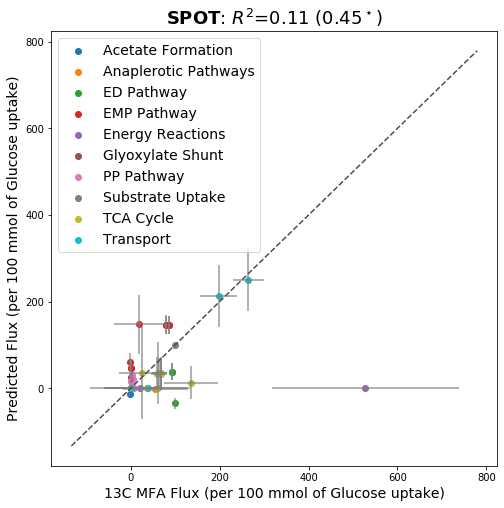

In [11]:
obs_vs_pred_scatter_plot_with_std(glucose_fluxes, substrate='glucose', method='SPOT', strain='WT', output_dir=output_dir)

#### **Display Glucose SPOT Flux Map**

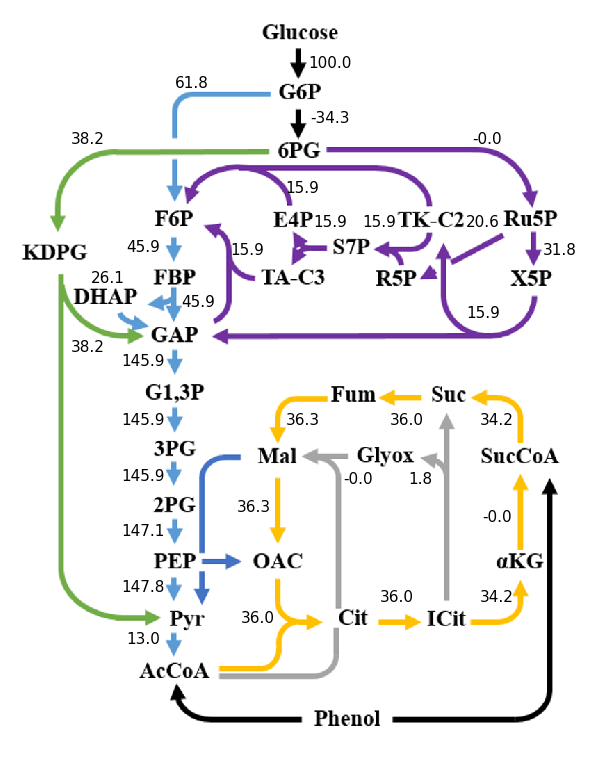

In [12]:
generate_flux_map(glucose_fluxes, 'SPOT WT Value', substrate='glucose', method='SPOT', strain='WT', output_dir=output_dir)

#### **Load experimental growth parameters from Notebook E**

In [13]:
consumption_and_growth_data = pd.read_csv('../data/growth_rates/experimental_growth_parameters.csv', index_col=0)
consumption_and_growth_data

,growth rate,yield coefficient,substrate consumption rate,growth rate std dev,yield coefficient std dev,substrate consumption rate std dev
WT-P,0.065488,0.048868,1.352072,0.001345,0.004836,0.122279
PVHG-P,0.080331,0.040848,1.967485,0.002672,0.001757,0.021785
WT-G,0.260195,0.072789,3.582471,0.004749,0.004117,0.141675


#### **Calculate SPOT Glucose Growth Rate**

In [14]:
# get experimental uptake rate from table
exp_uptake_rate = consumption_and_growth_data.loc['WT-G', 'substrate consumption rate']

# get average and standard deviation of growth rate from dataframes
average_growth_rate = average_spot_solution.loc['Growth_Glucose',:].values[0] 
std_growth_rate = std_spot_solution.loc['Growth_Glucose',:].values[0] 

# get average and standard deviation of uptake rate from dataframes
average_uptake_rate = average_spot_solution.loc['EX_glc__D_e',:].values[0] 
std_uptake_rate = std_spot_solution.loc['EX_glc__D_e',:].values[0] 

# normalize growth rate to experimental uptake rate
spot_growth_rate = -1 * exp_uptake_rate * (average_growth_rate / average_uptake_rate)
spot_growth_rate_std = -1 * exp_uptake_rate * (std_growth_rate / average_uptake_rate)

# Delete later
print(exp_uptake_rate)
print(average_growth_rate)
print('average uptake rate', average_uptake_rate)

3.582470920816068
-1.9617288481022098e-08
average uptake rate -100.0


#### **Add SPOT Glucose Data to Growth Rate Data**

In [15]:
consumption_and_growth_data['SPOT growth rate'] = [np.nan, np.nan, spot_growth_rate]
consumption_and_growth_data['SPOT growth std'] = [np.nan, np.nan, spot_growth_rate_std]
consumption_and_growth_data

,growth rate,yield coefficient,substrate consumption rate,growth rate std dev,yield coefficient std dev,substrate consumption rate std dev,SPOT growth rate,SPOT growth std
WT-P,0.065488,0.048868,1.352072,0.001345,0.004836,0.122279,NaN,NaN
PVHG-P,0.080331,0.040848,1.967485,0.002672,0.001757,0.021785,NaN,NaN
WT-G,0.260195,0.072789,3.582471,0.004749,0.004117,0.141675,-7.027837e-10,5.568057e-10


#### **Save SPOT Growth Rates**

In [16]:
consumption_and_growth_data.to_csv('../data/growth_rates/spot_growth_rates.csv', index=True, header=True)